# The Poisson-Boltzman Distribution

In order to understand lubrication better, we simulate thin layers of lubricant on a metallic surface, solvated in water.
Different structures of lubricant films are created by varying parameters like their concentration and the charge of the surface.
The lubricant is somewhat solvable in water, thus parts of the film will diffuse into the bulk water.
Lubricant molecules are charged, and their distribution is roughly exponential.

As simplification, we  first create a solution of ions (Na+, purple; Cl-, green) in water (not shown).
![pic](https://i.ibb.co/Yh8DxVM/showpicture.png)

Close to the positively charged metallic surface, the electric potential (red) will be highest, falling off exponentially when further away.
This potential attracts negatively charged Chlorine ions, and pushes positively charged Natrium ions away, resulting in a higher (lower) concentration of Clorine (Natrium) near the surface.



In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

# Sampling and plotting
from continuous2discrete import generate_structure 
from continuous2discrete import plot_dist
from continuous2discrete import get_histogram
from IPython.display import Image

In [67]:
# Physical distribution generation
from continuous2discrete.poisson_bolzmann_distribution import debye 
from continuous2discrete.poisson_bolzmann_distribution import gamma
from continuous2discrete.poisson_bolzmann_distribution import charge_density
from continuous2discrete.poisson_bolzmann_distribution import potential

np.random.seed(74)

To calculate this, we first need to find out how ions are distributed in solution.
A good description of the concentration of our ion species, $c_{Na^+}$, is given by the solution to the Poisson-Bolzmann equation:

$
\begin{align}
\rho_{Na^+}(z) &= \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}\\
\Psi(z) &= \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z} \\
\gamma &= \tanh(\frac{e\Psi(0)}{4k_B T})\\
\kappa &= 1/\lambda_D\\
\lambda_D &= \Big(\frac{\epsilon \epsilon_0 k_B T}{\sum_{i} \rho_i(\infty) e^2 z_i^2} \Big)^\frac{1}{2} [m^{-1}]
\end{align}
$

With:
* $z$: Distance from the double layer
* $\Psi(0)$: Potential at the surface
* $\Psi(z)$: Potential in the solution
* $k_B$: Bolzmann Constant
* $T$: Temperature [Kelvin]
* $e$: Elemental Charge (or Euler's constant when exponentiated)
* $\gamma$: Term from Gouy-Chapmann theory
    * $\gamma \rightarrow 1$ for high potentials
    * $\Psi(z) \approx \Psi_0 e^{-\kappa z}$ for low potentials $\Psi(0) \approx 0$
* $\lambda_D$: Debye Length (34.0 nm for NaCl, 10^-4 M, 25°C)
* $\rho_{Na^+}$: Concentration of Natrium ions
* $\rho_{Na^+}(\infty)$: Bulk Natrium concentration (at infinity, where the solution is homogeneous)
* $\epsilon$: Permittivity of the solution
* $\epsilon_0$: Electric constant aka Vacuum permittivity
* $z_i$: Charge of species i 


These equations are implemented in `poisson_bolzmann_distribution.py`

Debye Length of 10^-4 M saltwater: 30.52 nm (Target: 30.4 nm)


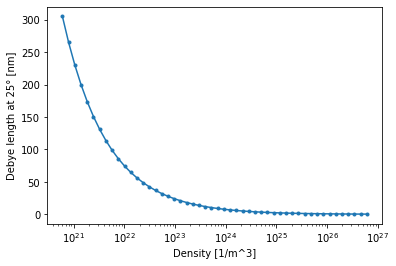

In [68]:
default_density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': default_density, 'Cl': default_density} 
charge = {'Na': 1, 'Cl': -1}
deb = debye(rho_bulk=rho, charge=charge) * 10**9
print('Debye Length of 10^-4 M saltwater: {} nm (Target: 30.4 nm)'.format(round(deb, 2)))

density = np.logspace(-6, 0, 50) * sc.Avogadro * 1000
debyes = [debye(rho_bulk={'Na': d, 'Cl': d}, charge=charge) * 10**9 for d in density]

plt.xlabel('Density [1/m^3]')
plt.ylabel('Debye length at 25° [nm]')
plt.semilogx(density, debyes, marker='.')
plt.show()

The debye length depends on the concentration of ions in solution, at low concentrations it becomes large. We can reproduce literature debye lengths with our function, so everything looks good.

## Gamma Function

Next we calculate the gamma function $\gamma = \tanh(\frac{e\Psi(0)}{4k_B T})$

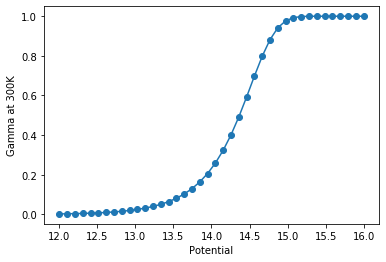

In [69]:
x = np.linspace(12, 16, 40)
gammas = [gamma(10 ** i, 300) for i in x]
plt.xlabel('Potential')
plt.ylabel('Gamma at 300K')
plt.plot(x, gammas, marker='o')
plt.show()

Which looks as expected, but we have no values to compare it against.

## Potential

We plug these two functions into the expression for the potential

$\Psi(z) = \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z}$

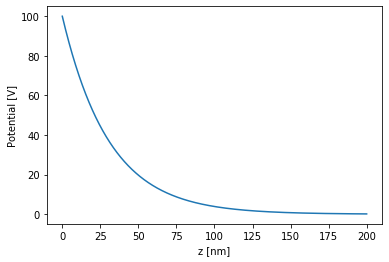

In [70]:
z = np.linspace(0, 2*10**-7, 10000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 100
psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

The potential is smooth and looks roughly exponential. Everything good so far.

## Charge density

Now we obtain the charge density $\rho$ from the potential $\Psi$ via

$\rho_{Na^+}(z) = \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}$

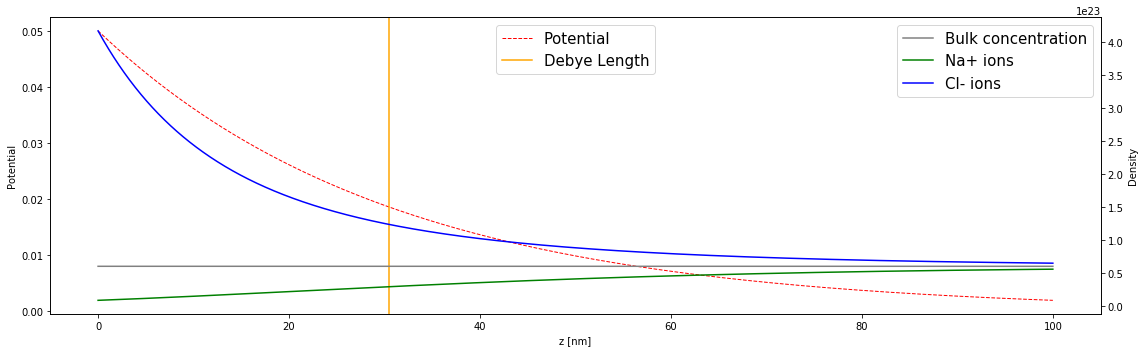

In [71]:
z = np.linspace(0, 100*10**-9, 2000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 10**9

fig, ax1 = plt.subplots(figsize=[16,5])
ax1.set_xlabel('z [nm]')
ax1.plot(z*10**9, psi, marker='', color='red', label='Potential', linewidth=1, linestyle='--')
ax1.set_ylabel('Potential')
ax1.axvline(x=deb, label='Debye Length', color='orange')

ax2 = ax1.twinx()
ax2.plot(z*10**9, [density]*len(z), label='Bulk concentration', color='grey')
ax2.plot(z*10**9, rho_na, marker='', color='green', label='Na+ ions')
ax2.plot(z*10**9, rho_cl, marker='', color='blue', label='Cl- ions')
ax2.set_ylabel('Density')

#fig.legend(loc='center')
ax2.legend(loc='best', fontsize=15)
ax1.legend(loc='upper center', fontsize=15)
fig.tight_layout()
plt.show()

The charge density behaves as expected, it interpolates between low (high) concentration and the bulk concentration within the first few debye lengths.

## Sampling
Now let's see if we can just plug our new distribution in our existing framework.

First, we need to convert the physical distribution to the format we were using so far:

In [7]:
def wrap_distribution(x, species):
    """Wrapper for na+ ions."""
    density = sc.Avogadro * 1000 * 10**-4
    rho = {'Na': density, 'Cl':density} 
    charge = {'Na': 1, 'Cl': -1}
    pot_0 = 0.05  # Breaks if > 1
    
    def call_distri(loc):
        distri = charge_density(location=loc, rho_bulk=rho, 
                                charge=charge, surface_potential=pot_0, species=species)
        return float(distri)
    
    if not np.isscalar(x):
        y = []
        for i in range(0, len(x)):
            val = call_distri(x[i])
            
            # Normalize to be 1 at x=0
            val /= call_distri(0)
            # Scale distribution to have values in [0, 0.1] for ease of sampling
            val /= 10
            y += [val]
        return np.array(y)

    # If we have only a point estimate
    val = call_distri(x)
    # Normalize to be 1 at x=0
    val /= call_distri(0)
    # Scale distribution to have values in [0, 0.1] for ease of sampling
    val /= 10    
    return val
    
def cl_distribution(x):
    return wrap_distribution(x, species='Cl')

def na_distribution(x):
    return wrap_distribution(x, species='Na')

Now we can sample the distribution of our $Na^+$ ions in z-direction.

In [8]:
x = 50 * 10**-9
z = 100 * 10**-9
box = np.array([x, x, z])
sample_size = 10000

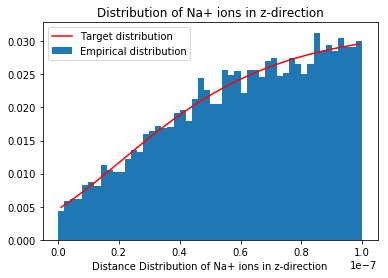

In [9]:
struc = generate_structure(distribution=na_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)

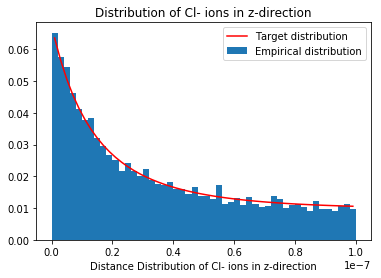

In [10]:
struc = generate_structure(distribution=cl_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

## Write to file
To visualize our structure, we export it to the .xyz file format, which is basically

```
ATOM_NUMBER
Optional comment
atom_type x y z
atom_type x y z
```

Avogadro expects x, y, z to be in units of $10^{-9}~m$, so we convert our salt "solution" to this unit.

Also, we use fewer atoms, just 100 for the 100x50x50 box - this will increase fluctuations with respect to the correct distribution though.

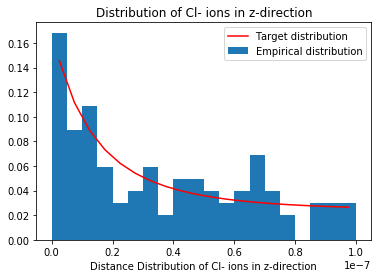

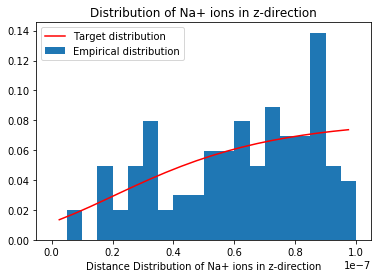

In [11]:
from generate_structure import concat_names_structs
from generate_structure import export_named_struc

cl_struc = generate_structure(distribution=cl_distribution, box=box, atom_count=100)
na_struc = generate_structure(distribution=na_distribution, box=box, atom_count=100)

concat_list = concat_names_structs(struc_list=[cl_struc, na_struc], name_list=['Cl', 'Na'])
rescaled_list = []
for line in concat_list:
    name, x, y, z = line
    x = float(x) * 10**9
    y = float(y) * 10**9
    z = float(z) * 10**9    
    rescaled_list += [[name, x, y, z]]

rescaled_list = np.array(rescaled_list)
export_named_struc(rescaled_list)

histx, histy, histz = get_histogram(cl_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

histx, histy, histz = get_histogram(na_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)

Now we can import the xyz file into avogadro, the visualization should look like this:

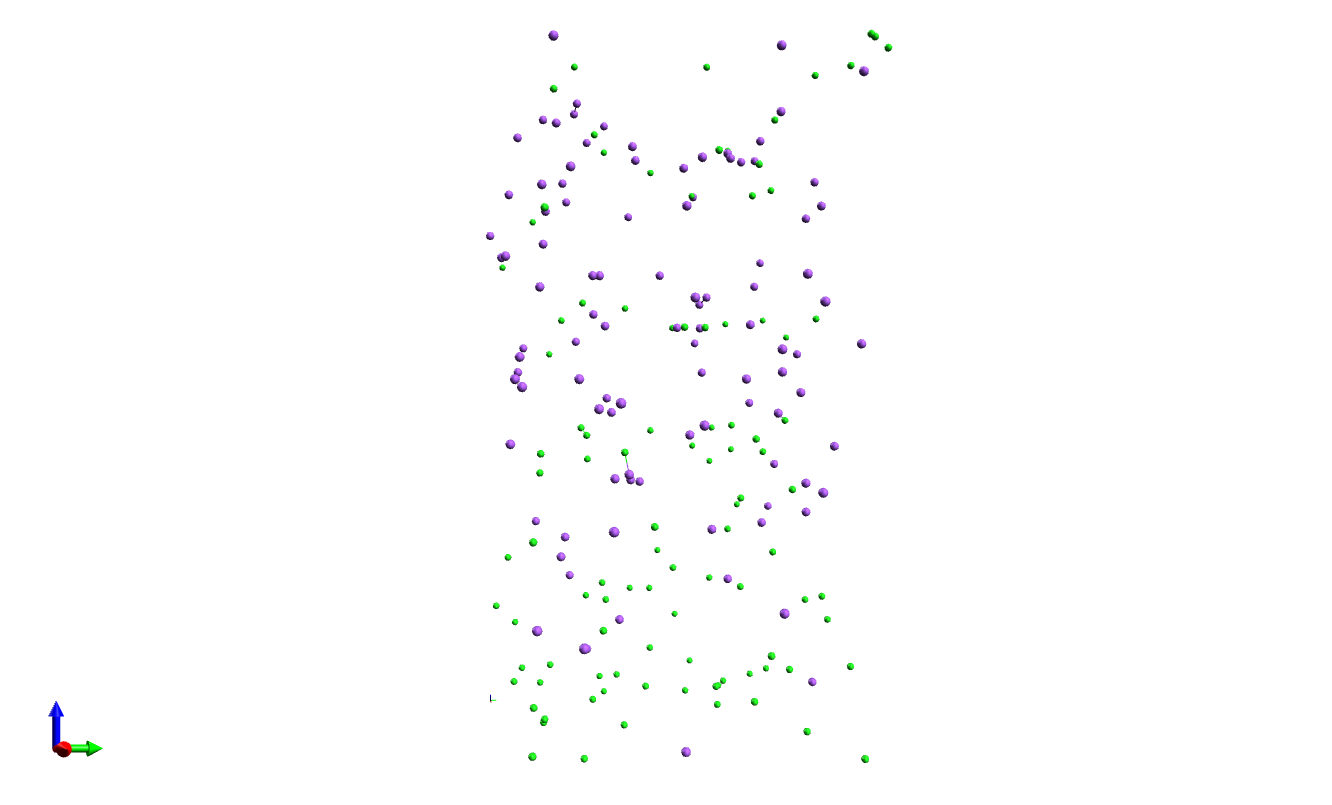

In [12]:
Image(filename='distributed_atom_structure.png') 

# General Poisson-Nernst-Planck System

In [965]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

A binary Poisson-Nernst-Planck system corresponds to the transport problem in semiconductor physics.
In this context, Debye length, charge carrier densities and potential are related as follows.

## Excursus: Transport problem in PNP junction (German)

### Debye length

Woher kommt die Debye-Länge

$$ \lambda = \sqrt{ \frac{\varepsilon \varepsilon_0 k_B T}{q^2 n_i} }$$

als natürliche Längeneinheit des Transportptoblems?

Hier ist $n_i$ eine Referenzladungsträgerdichte, in der Regel die intrinsische Ladungsträgerdichte. 
In dem Beispiel mit $N^+NN^+$-dotiertem Halbleiter erzeugen wir durch unterschiedliches Doping an den Rändern die erhöhte Donatorendichte $N_D^+ = 10^{20} \mathrm{cm}^{-3}$ und im mitteleren Bereich "Standarddonatorendichte" $N_D = 10^{18} \mathrm{cm}^{-3}$. Nun können wir als Referenz $n_i = N_D$ wählen und die Donatorendichten als $N_D = 1 \cdot n_i$ und $N_D^+ = 100 \cdot n_i$ ausdrücken. Diese normierte Konzentration nennen wir einfach $\tilde{N}_D$: $N_D = \tilde{N}_D \cdot n_i$.

Ein ionisierter Donator trägt die Ladung $q$, ein Ladungsträger (in unserem Fall ein Elektron) trägt die Elementarladung $-q$. Die Raumladungsdichte $\rho$ in der Poissongleichung

$$ \nabla^2 \varphi = - \frac{\rho}{\varepsilon \varepsilon_0}$$

lässt sich also ganz einfach als $\rho = - (n - N_D) \cdot q = - (\tilde{n} - \tilde{N}_D) ~ n_i ~ q$ ausdrücken. 

Konventionell wird das Potential auf $u = \frac{\phi ~ q}{k_B ~ T}$ normiert. Die Poissongleichung nimmt damit die Form

$$\frac{k_B ~ T}{q} \cdot \nabla^2 u = \frac{(\tilde{n} - \tilde{N}_D) ~ n_i ~ q }{\varepsilon \varepsilon_0}$$

oder auch 

$$ \frac{\varepsilon ~ \varepsilon_0 ~ k_B ~ T}{q^2 n_i} \cdot \nabla^2 u = \lambda^2 \cdot \nabla^2 u = \tilde{n} - \tilde{N}_D$$



### Dimensionless formulation

Poisson- und Drift-Diffusionsgleichung

$$ 
\lambda^2 \frac{\partial^2 u}{\partial x^2} = n - N_D
$$

$$ 
\frac{\partial n}{\partial t} = - D_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R
$$

Skaliert mit [l], [t]:

$$ 
\frac{\lambda^2}{[l]^2} \frac{\partial^2 u}{\partial \tilde{x}^2} = n - N
$$

und

$$ 
\frac{1}{[t]} \frac{\partial n}{\partial \tilde{t}} = - \frac{D_n}{[l]^2} \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R 
$$

oder

$$ 
\frac{\partial n}{\partial \tilde{t}} = - \tilde{D}_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) +  \tilde{R} 
$$

mit 

$$ 
\tilde{D}_n = D_n \frac{[t]}{[l]^2} \Leftrightarrow [t] = [l]^2 \ \frac{ \tilde{D}_n } { D_n } 
$$
    
und

$$ \tilde{R} = \frac{n - N_D}{\tilde{\tau}}$$ 

mit $\tilde{\tau} = \tau / [t]$. 

$\tilde{\lambda} = 1$ und $\tilde{D_n} = 1$ werden mit
$[l] = \lambda$ und $[t] = \frac{\lambda^2}{D_n}$ erreicht:

### Discretization

Naive Diskretisierung (skaliert):

$$ \frac{1}{\Delta x^2} ( u_{i+1}-2u_i+u_{i-1} ) = n_i - N_i $$

$$ \frac{1}{\Delta t} ( n_{i,j+1} - n_{i,j} ) = - \frac{1}{\Delta x^2} \cdot \left[ \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) \right] + \frac{ n_i - N_i}{ \tilde{\tau} } $$

Stationär:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

### Newton-Iteration für gekoppeltes nicht-lineares Gleichungssystem

Idee: Löse nicht-lineares Finite-Differenzen-Gleichungssystem über Newton-Verfahren  

$$ \vec{F}(\vec{x}_{k+1}) = F(\vec{x}_k + \Delta \vec{x}_k) \approx F(\vec{x}_k) + \mathbf{J_F}(\vec{x}_k) \cdot \Delta \vec{x}_k + \mathcal{O}(\Delta x^2)$$
   
mit Unbekannter $\vec{x_k} = \{u_1^k, \dots, u_N^k, n_1^k, \dots, n_N^k\}$  und damit

$$ \Rightarrow \Delta \vec{x}_k = - \mathbf{J}_F^{-1} ~ F(\vec{x}_k)$$

wobei die Jacobi-Matrix $2N \times 2N$ Einträge

$$ \mathbf{J}_{ij}(\vec{x}_k) = \frac{\partial F_i}{\partial x_j} (\vec{x}_k) $$

besitzt, die bei jedem Iterationsschritt für $\vec{x}_k$ ausgewertet werden.
Der tatsächliche Aufwand liegt in der Invertierung der Jacobi-Matrix, um in jeder Iteration $k$ den Korrekturschritt $\Delta \vec{x}_k$ zu finden.m

$F(x)$ wird wie unten definiert als:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

### Controlled-Volume

Drücke nicht-linearen Teil der Transportgleichung (genauer, des Flusses) über Bernoulli-Funktionen 

$$ B(x) = \frac{x}{\exp(x)-1} $$ 

aus (siehe Vorlesungsskript). Damit wir in der Nähe von 0 nicht "in die Bredouille geraten", verwenden wir hier lieber die Taylorentwicklung. In der Literatur (Selbherr, S. Analysis and Simulation of Semiconductor Devices, Spriger 1984) wird eine noch aufwendigere stückweise Definition empfohlen, allerdings werden wir im Folgenden sehen, dass unser Ansatz für dieses stationäre Problem genügt.


## Implementation for Poisson-Nernst-Planck system

Poisson-Nernst-Planck system for $k = {1 \dots M}$ ion species in dimensionless formulation

$$ \nabla^2 u + \rho(n_{1},\dots,n_{M}) = 0 $$

$$ \nabla^2 n_k + \nabla ( z_k n_k \nabla u ) = 0 \quad \text{for} \quad k = 1 \dots M $$

yields a naive finite difference discretization on $i = {1 \dots N}$ grid points for $k = {1 \dots M}$ ion species

$$ \frac{1}{\Delta x^2} ( u_{i+1}-2u_i+u_{i-1} )  + \frac{1}{2} \sum_{k=1}^M z_k n_{i,k} = 0 $$

$$ - \frac{1}{\Delta x^2} \cdot \left[ \frac{1}{4} z_k (n_{i+1,k} - n_{i-1,k}) (u_{i+1} - u_{i-1}) + z_k n_{i,k} ( u_{i+1} - 2 u_i + u_{i-1} ) + ( n_{i+1,k} - 2 n_{i,k} + n_{i-1,k} ) \right] $$

or rearranged

$$ u_{i+1}-2 u_i+u_{i-1} + \Delta x^2 \frac{1}{2} \sum_{k=1}^M z_k n_{i,k}  = 0 $$

and

$$
  \frac{1}{4} z_k (n_{i+1,k} - n_{i-1,k}) (u_{i+1,k} - u_{i-1,k}) + z_k n_{i,k} ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1,k} - 2 n_{i,k} + n_{i-1,k} ) = 0
$$

### Controlled-Volume

Instead, we express non-linear part of the Nernts-Planck equations with Bernoulli function

$$ B(x) = \frac{x}{\exp(x)-1} $$ 

(Selberherr, S. Analysis and Simulation of Semiconductor Devices, Spriger 1984)

In [1144]:
def B(x):
    return np.where( np.abs(x) < 1e-9,
        1 - x/2 + x**2/12 - x**4/720, # Taylor
        x / ( np.exp(x) - 1 ) )

In [1145]:
xB = np.arange(-10,10,0.1)

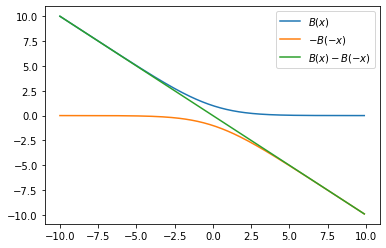

In [1148]:
plt.plot( xB ,B( xB ), label="$B(x)$")
plt.plot( xB, - B(-xB), label="$-B(-x)$")
plt.plot( xB, B(xB)-B(-xB), label="$B(x)-B(-x)$")
plt.legend()

In [1149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1150]:
import matplotlib.pyplot as plt
from continuous2discrete.poisson_nernst_planck_distribution import PoissonNernstPlanckSystem

In [1151]:
# configure logging: verbosity level and format as desired
standard_loglevel   = logging.INFO
standard_logformat  = ''.join(("%(asctime)s",
  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))

import logging
# reset logger if previously loaded
logging.shutdown()

logging.basicConfig(level=standard_loglevel,
                    format=standard_logformat,
                    datefmt='%m-%d %H:%M')

# in Jupyter notebooks, explicitly modifying the root logger necessary
logger = logging.getLogger()
logger.setLevel(standard_loglevel)

# remove all handlers
for h in logger.handlers: logger.removeHandler(h)

# create and append custom handles
ch = logging.StreamHandler()
formatter = logging.Formatter(standard_logformat)
ch.setFormatter(formatter)
ch.setLevel(standard_loglevel)
logger.addHandler(ch)

In [1152]:
# Test 1
logging.info("Root logger")

2019-10-29 20:42:24,924[ <ipython-input-1152-adec08aea02d>:2 - <module>() ]: Root logger


In [1153]:
# Test 2
logger.info("Root Logger")

2019-10-29 20:42:25,255[ <ipython-input-1153-4335e316391c>:2 - <module>() ]: Root Logger


### Test case 1: 0.1 mM NaCl, positive potential u = 0.05 V

In [1154]:
L = 1e-7 # 1 mu_m

In [1155]:
# define desired system
del pnp
pnp = PoissonNernstPlanckSystem(L=L)
# constructor takes keyword arguments
#   c=array([0.1, 0.1]), z=array([ 1, -1]), L=1e-07, T=298.15, delta_u=0.05, relative_permittivity=79, vacuum_permittivity=8.854187817620389e-12, R=8.3144598, F=96485.33289
# with default values set for 0.1 mM NaCl aqueous solution across 100 nm  and 0.05 V potential drop

2019-10-29 20:42:26,890[ poisson_nernst_planck_distribution.py:683 - __init__() ]: ion species 00 concentration c                0.1
2019-10-29 20:42:26,891[ poisson_nernst_planck_distribution.py:685 - __init__() ]: ion species 00 number charge z                  1
2019-10-29 20:42:26,892[ poisson_nernst_planck_distribution.py:683 - __init__() ]: ion species 01 concentration c                0.1
2019-10-29 20:42:26,892[ poisson_nernst_planck_distribution.py:685 - __init__() ]: ion species 01 number charge z                 -1
2019-10-29 20:42:26,892[ poisson_nernst_planck_distribution.py:688 - __init__() ]: temperature T                               298.1
2019-10-29 20:42:26,893[ poisson_nernst_planck_distribution.py:690 - __init__() ]: domain size L                               1e-07
2019-10-29 20:42:26,893[ poisson_nernst_planck_distribution.py:692 - __init__() ]: potential difference delta_u                 0.05
2019-10-29 20:42:26,894[ poisson_nernst_planck_distribution.py:694 - 

In [1156]:
# technical settings
pnp.output = True # makes Newton solver display convergence plots
pnp.N = 200       # uniformly distanced grid points
pnp.maxit = 20    # maximum number of Newton iterations
pnp.outfreq = 2   # plot every 2nd step
pnp.e = 1e-10     # tolerance

In [1157]:
pnp.useStandardInterfaceBC()

2019-10-29 20:42:28,258[ poisson_nernst_planck_distribution.py:353 - useStandardInterfaceBC() ]: Left hand side Dirichlet boundary condition:                               u0 =    1.946
2019-10-29 20:42:28,259[ poisson_nernst_planck_distribution.py:354 - useStandardInterfaceBC() ]: Right hand side Dirichlet boundary condition:                              u1 =        0
2019-10-29 20:42:28,259[ poisson_nernst_planck_distribution.py:363 - useStandardInterfaceBC() ]: Ion species 00 left hand side concentration Flux boundary condition:       j0 =        0
2019-10-29 20:42:28,260[ poisson_nernst_planck_distribution.py:364 - useStandardInterfaceBC() ]: Ion species 00 right hand side concentration Dirichlet boundary condition: c1 =        1
2019-10-29 20:42:28,260[ poisson_nernst_planck_distribution.py:363 - useStandardInterfaceBC() ]: Ion species 01 left hand side concentration Flux boundary condition:       j0 =        0
2019-10-29 20:42:28,261[ poisson_nernst_planck_distribution.py:364 - u

In [1158]:
pnp.init()

2019-10-29 20:42:28,738[ poisson_nernst_planck_distribution.py:246 - init() ]: discretization segments N                     200
2019-10-29 20:42:28,738[ poisson_nernst_planck_distribution.py:248 - init() ]: grid points N                                 201
2019-10-29 20:42:28,739[ poisson_nernst_planck_distribution.py:263 - init() ]: dx                                        0.01638
2019-10-29 20:42:28,740[ poisson_nernst_planck_distribution.py:265 - init() ]: dx2overtau                                     10


In [1159]:
# initial config
z = np.linspace(0, pnp.L, pnp.Ni)
# density = sc.Avogadro * 1000 * 1e-4
density = sc.Avogadro * 1000 * 1e-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = pnp.delta_u  # Breaks if > 1

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pnp.delta_u, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pnp.delta_u, species='Cl') for loc in z])

c_na = rho_na / sc.Avogadro
c_cl = rho_cl / sc.Avogadro


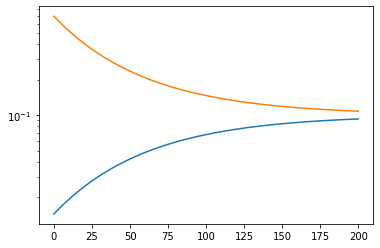

In [1160]:
plt.semilogy(c_na)
plt.semilogy(c_cl)

In [1161]:
ni0 = np.vstack([ c_na, c_cl ]) / pnp.c_unit

In [1162]:
pnp.ni0 = ni0

In [1163]:
ui0 = pnp.initial_values()

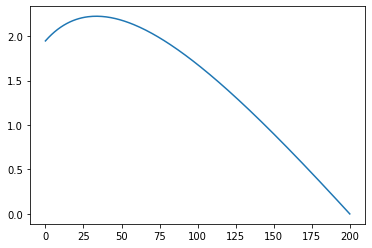

In [1164]:
plt.plot(ui0)

2019-10-29 20:42:52,760[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    0: norm(dx)/norm(x) = 3.42e-01, norm(dx) = 1.46e+01, norm(F) = 1.24e+00
2019-10-29 20:42:53,941[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    2: norm(dx)/norm(x) = 4.49e-04, norm(dx) = 1.63e-02, norm(F) = 9.26e-04
2019-10-29 20:42:55,094[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    4: norm(dx)/norm(x) = 3.69e-13, norm(dx) = 1.34e-11, norm(F) = 1.38e-12
2019-10-29 20:42:55,116[ poisson_nernst_planck_distribution.py:218 - newton() ]: Ended after 5 steps.


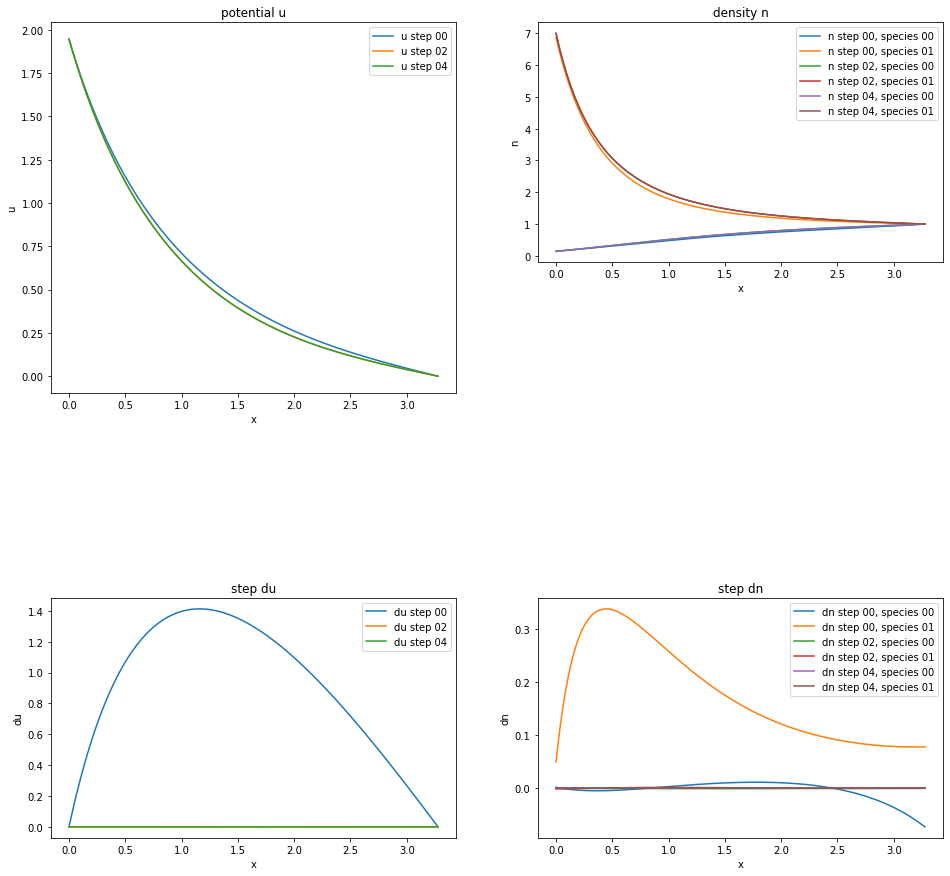

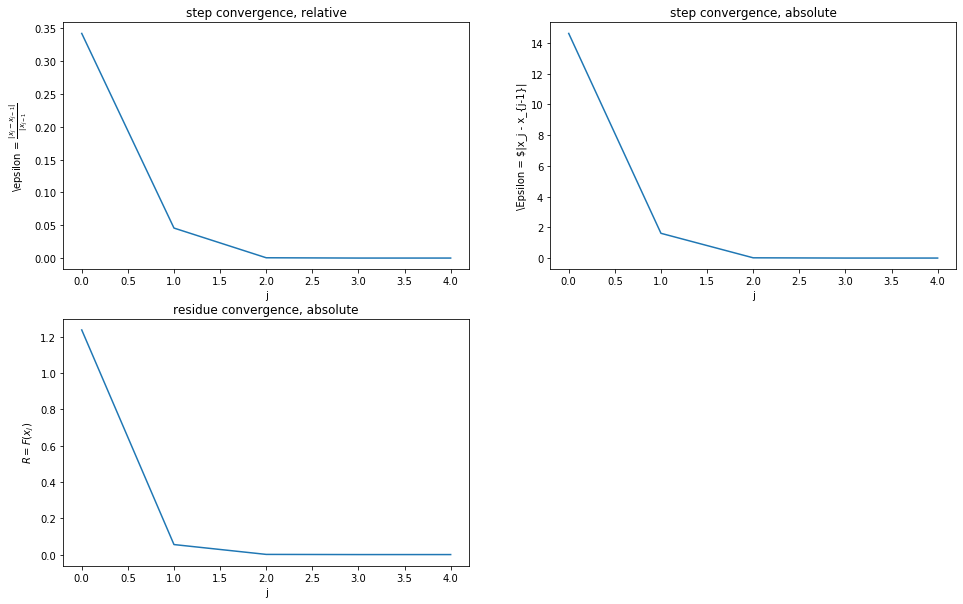

In [1166]:
uij, nij, lamj = pnp.solve()

### Validation: Analytical half-space solution & Numerical finite-size PNP system

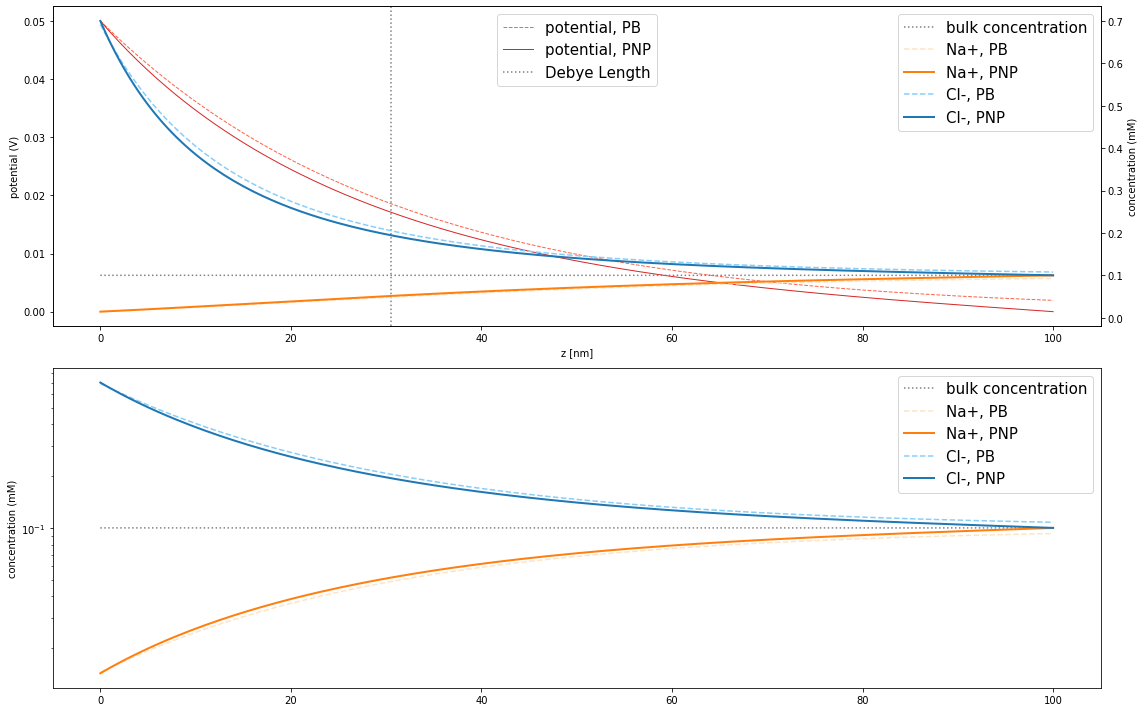

In [1167]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system

z = np.linspace(0, L, 2000)
density = sc.Avogadro * 1000 * 1e-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 1e9

fig, (ax1,ax3) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(z*1e9, psi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid*1e9, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax1.set_ylabel('potential (V)')

ax2 = ax1.twinx()
ax2.plot(z*1e9, [density/sc.Avogadro]*len(z), label='bulk concentration', color='grey', linestyle=':')
ax2.plot(z*1e9, rho_na/sc.Avogadro, marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax2.plot(z*1e9, rho_cl/sc.Avogadro, marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax2.set_ylabel('concentration (mM)')

ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3.semilogy(z*1e9, [density/sc.Avogadro]*len(z), label='bulk concentration', color='grey', linestyle=':')
ax3.semilogy(z*1e9, rho_na/sc.Avogadro, marker='', color='bisque', label='Na+, PB',linestyle='--')
ax3.semilogy(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax3.semilogy(z*1e9, rho_cl/sc.Avogadro, marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax3.semilogy(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper center', fontsize=15)
ax2.legend(loc='best', fontsize=15)
ax3.legend(loc='upper right', fontsize=15)

fig.tight_layout()
plt.show()

In [1168]:
(pnp.potential[0],pnp.potential[-1])

(0.05, 3.164344665751301e-32)

In [1169]:
pnp.concentration[0,0]

0.014283329025079956

In [1170]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.014283329025079956, 0.1)

In [1171]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(0.7001470986519073, 0.1)

### Test case 2: 0.1 mM NaCl, positive potential u = -0.05 V

In [1172]:
L = 1e-7 # 1 mu_m
delta_u=-0.05

In [1173]:
# define desired system
del pnp
pnp = PoissonNernstPlanckSystem(L=L,delta_u=delta_u)
# constructor takes keyword arguments
#   c=array([0.1, 0.1]), z=array([ 1, -1]), L=1e-07, T=298.15, delta_u=0.05, relative_permittivity=79, vacuum_permittivity=8.854187817620389e-12, R=8.3144598, F=96485.33289
# with default values set for 0.1 mM NaCl aqueous solution across 100 nm  and 0.05 V potential drop

2019-10-29 20:43:13,138[ poisson_nernst_planck_distribution.py:683 - __init__() ]: ion species 00 concentration c                0.1
2019-10-29 20:43:13,139[ poisson_nernst_planck_distribution.py:685 - __init__() ]: ion species 00 number charge z                  1
2019-10-29 20:43:13,139[ poisson_nernst_planck_distribution.py:683 - __init__() ]: ion species 01 concentration c                0.1
2019-10-29 20:43:13,140[ poisson_nernst_planck_distribution.py:685 - __init__() ]: ion species 01 number charge z                 -1
2019-10-29 20:43:13,140[ poisson_nernst_planck_distribution.py:688 - __init__() ]: temperature T                               298.1
2019-10-29 20:43:13,140[ poisson_nernst_planck_distribution.py:690 - __init__() ]: domain size L                               1e-07
2019-10-29 20:43:13,141[ poisson_nernst_planck_distribution.py:692 - __init__() ]: potential difference delta_u                -0.05
2019-10-29 20:43:13,141[ poisson_nernst_planck_distribution.py:694 - 

In [1174]:
# technical settings
pnp.output = True # makes Newton solver display convergence plots
pnp.N = 200       # uniformly distanced grid points
pnp.maxit = 20    # maximum number of Newton iterations
pnp.outfreq = 2   # plot every 2nd step
pnp.e = 1e-11     # tolerance

In [1175]:
pnp.useStandardInterfaceBC()

2019-10-29 20:43:16,755[ poisson_nernst_planck_distribution.py:353 - useStandardInterfaceBC() ]: Left hand side Dirichlet boundary condition:                               u0 =   -1.946
2019-10-29 20:43:16,755[ poisson_nernst_planck_distribution.py:354 - useStandardInterfaceBC() ]: Right hand side Dirichlet boundary condition:                              u1 =        0
2019-10-29 20:43:16,756[ poisson_nernst_planck_distribution.py:363 - useStandardInterfaceBC() ]: Ion species 00 left hand side concentration Flux boundary condition:       j0 =        0
2019-10-29 20:43:16,756[ poisson_nernst_planck_distribution.py:364 - useStandardInterfaceBC() ]: Ion species 00 right hand side concentration Dirichlet boundary condition: c1 =        1
2019-10-29 20:43:16,756[ poisson_nernst_planck_distribution.py:363 - useStandardInterfaceBC() ]: Ion species 01 left hand side concentration Flux boundary condition:       j0 =        0
2019-10-29 20:43:16,757[ poisson_nernst_planck_distribution.py:364 - u

In [1176]:
pnp.init()

2019-10-29 20:43:16,973[ poisson_nernst_planck_distribution.py:246 - init() ]: discretization segments N                     200
2019-10-29 20:43:16,974[ poisson_nernst_planck_distribution.py:248 - init() ]: grid points N                                 201
2019-10-29 20:43:16,975[ poisson_nernst_planck_distribution.py:263 - init() ]: dx                                        0.01638
2019-10-29 20:43:16,976[ poisson_nernst_planck_distribution.py:265 - init() ]: dx2overtau                                     10


In [1177]:
# initial config
z = np.linspace(0, pnp.L, pnp.Ni)
# density = sc.Avogadro * 1000 * 1e-4
density = sc.Avogadro * 1000 * 1e-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = pnp.delta_u  # Breaks if > 1

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pnp.delta_u, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pnp.delta_u, species='Cl') for loc in z])

c_na = rho_na / sc.Avogadro
c_cl = rho_cl / sc.Avogadro


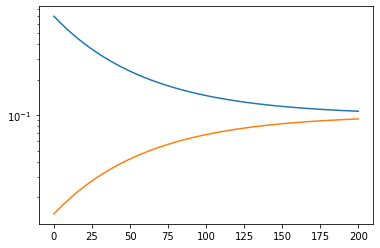

In [1178]:
plt.semilogy(c_na)
plt.semilogy(c_cl)

In [1179]:
ni0 = np.vstack([ c_na, c_cl ]) / pnp.c_unit

In [1180]:
pnp.ni0 = ni0

In [1181]:
ui0 = pnp.initial_values()

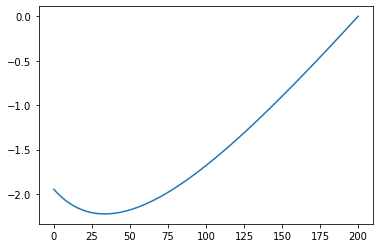

In [1182]:
plt.plot(ui0)

2019-10-29 20:43:20,652[ poisson_nernst_planck_distribution.py:145 - newton() ]: Convergence criterion: norm(dx) < 1.00e-11
2019-10-29 20:43:21,217[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    0: norm(dx)/norm(x) = 3.42e-01, norm(dx) = 1.46e+01, norm(F) = 1.24e+00
2019-10-29 20:43:22,442[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    2: norm(dx)/norm(x) = 4.49e-04, norm(dx) = 1.64e-02, norm(F) = 9.26e-04
2019-10-29 20:43:23,601[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    4: norm(dx)/norm(x) = 1.08e-13, norm(dx) = 3.94e-12, norm(F) = 1.00e-12
2019-10-29 20:43:23,624[ poisson_nernst_planck_distribution.py:218 - newton() ]: Ended after 5 steps.


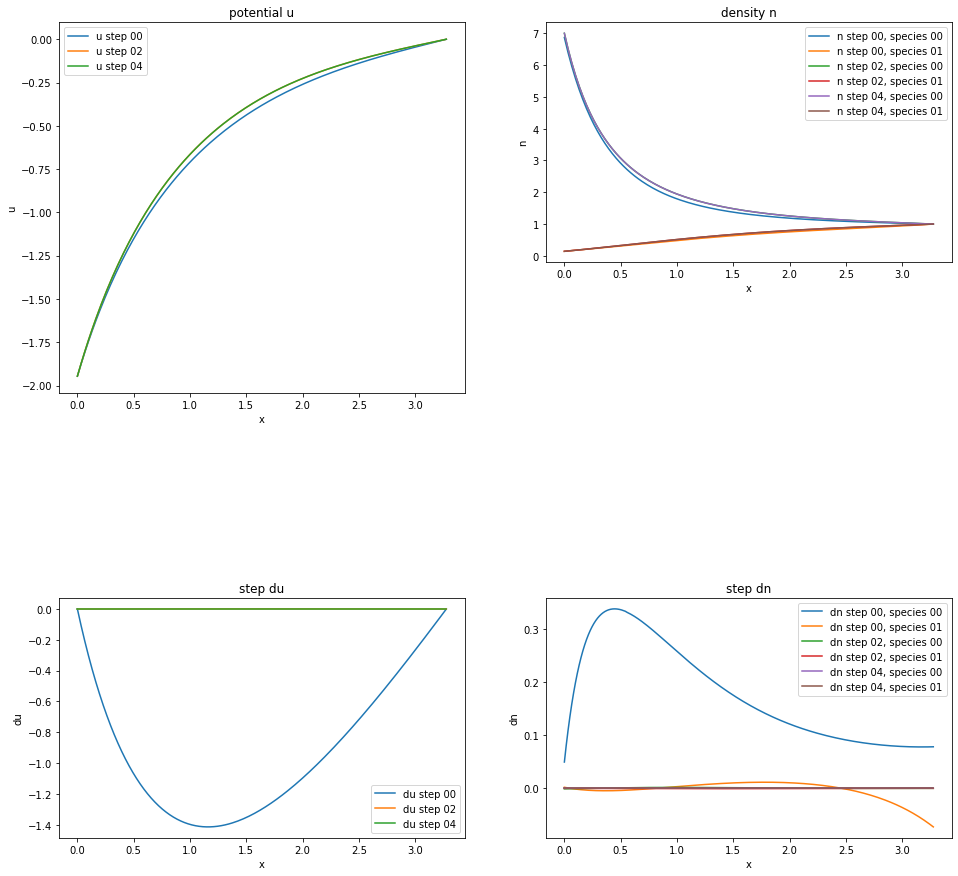

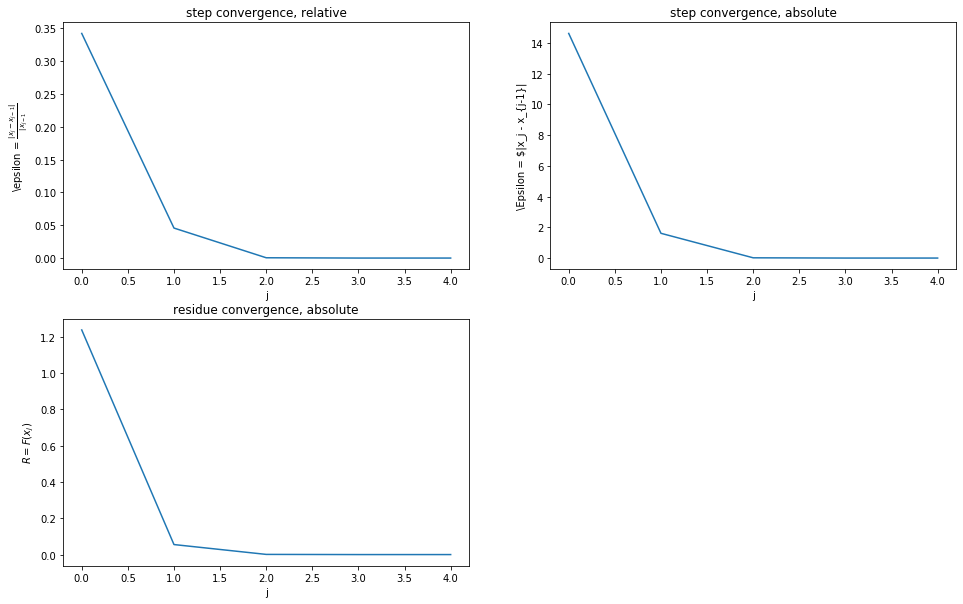

In [1183]:
uij, nij, lamj = pnp.solve()

### Validation: Analytical half-space solution & Numerical finite-size PNP system

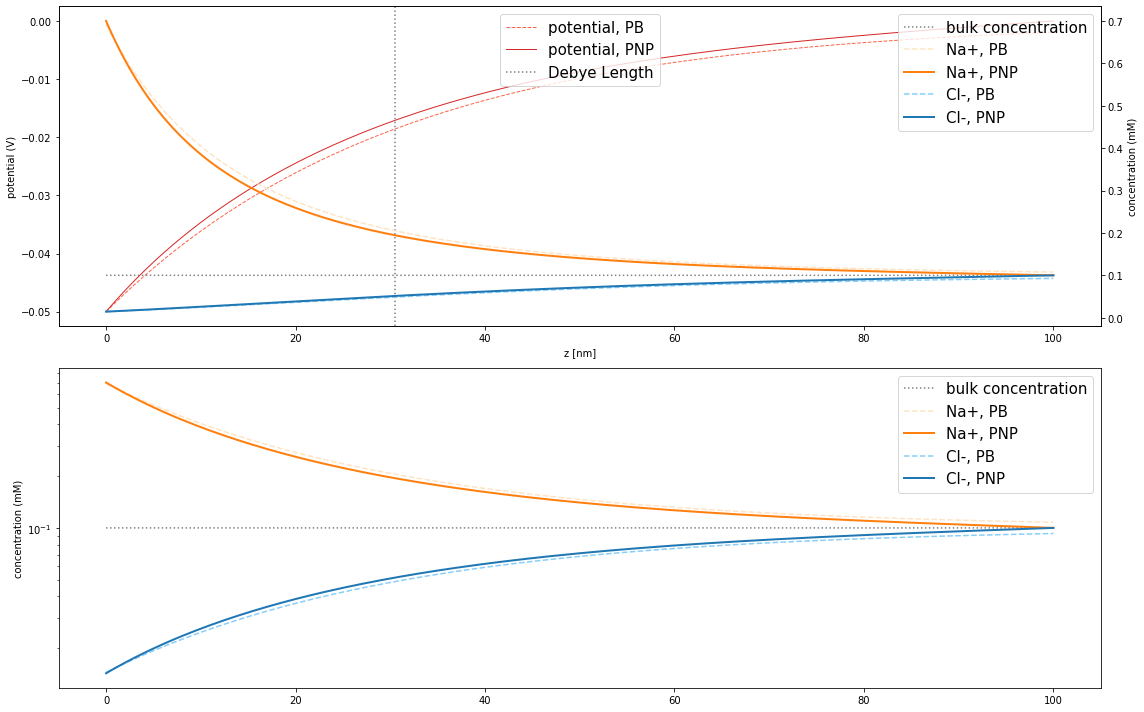

In [1184]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system

z = np.linspace(0, L, 2000)
density = sc.Avogadro * 1000 * 1e-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = delta_u  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 1e9

fig, (ax1,ax3) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(z*1e9, psi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid*1e9, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax1.set_ylabel('potential (V)')

ax2 = ax1.twinx()
ax2.plot(z*1e9, [density/sc.Avogadro]*len(z), label='bulk concentration', color='grey', linestyle=':')
ax2.plot(z*1e9, rho_na/sc.Avogadro, marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax2.plot(z*1e9, rho_cl/sc.Avogadro, marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax2.set_ylabel('concentration (mM)')

ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3.semilogy(z*1e9, [density/sc.Avogadro]*len(z), label='bulk concentration', color='grey', linestyle=':')
ax3.semilogy(z*1e9, rho_na/sc.Avogadro, marker='', color='bisque', label='Na+, PB',linestyle='--')
ax3.semilogy(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax3.semilogy(z*1e9, rho_cl/sc.Avogadro, marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax3.semilogy(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper center', fontsize=15)
ax2.legend(loc='best', fontsize=15)
ax3.legend(loc='upper right', fontsize=15)

fig.tight_layout()
plt.show()

In [1185]:
(pnp.potential[0],pnp.potential[-1])

(-0.05, 2.356973932017584e-31)

In [1186]:
pnp.concentration[0,0]

0.7001470986520503

In [1187]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.7001470986520503, 0.1)

In [1188]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(0.014283329025077084, 0.1)

### Test case 3

In [1197]:
L = 2e-7 # 200 nm

In [1198]:
del pnp

In [1199]:
# define desired system
pnp = PoissonNernstPlanckSystem(L=L)
# constructor takes keyword arguments
#   c=array([0.1, 0.1]), z=array([ 1, -1]), L=1e-07, T=298.15, delta_u=0.05, relative_permittivity=79, vacuum_permittivity=8.854187817620389e-12, R=8.3144598, F=96485.33289
# with default values set for 0.1 mM NaCl aqueous solution across 100 nm  and 0.05 V potential drop

In [1200]:
# technical settings
pnp.output = True # makes Newton solver display convergence plots
pnp.N = 200       # uniformly distanced grid points
pnp.maxit = 20    # maximum number of Newton iterations
pnp.outfreq = 2   # plot every 2nd step
pnp.e = 1e-10     # tolerance

In [1201]:
pnp.useStandardInterfaceBC()

In [1202]:
pnp.init()

2019-10-29 20:44:50,541[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    0: norm(dx)/norm(x) = 6.35e-01, norm(dx) = 1.63e+01, norm(F) = 1.96e-01
2019-10-29 20:44:51,714[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    2: norm(dx)/norm(x) = 3.96e-03, norm(dx) = 1.17e-01, norm(F) = 5.55e-02
2019-10-29 20:44:52,891[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    4: norm(dx)/norm(x) = 1.02e-11, norm(dx) = 3.03e-10, norm(F) = 1.05e-10
2019-10-29 20:44:52,913[ poisson_nernst_planck_distribution.py:218 - newton() ]: Ended after 5 steps.


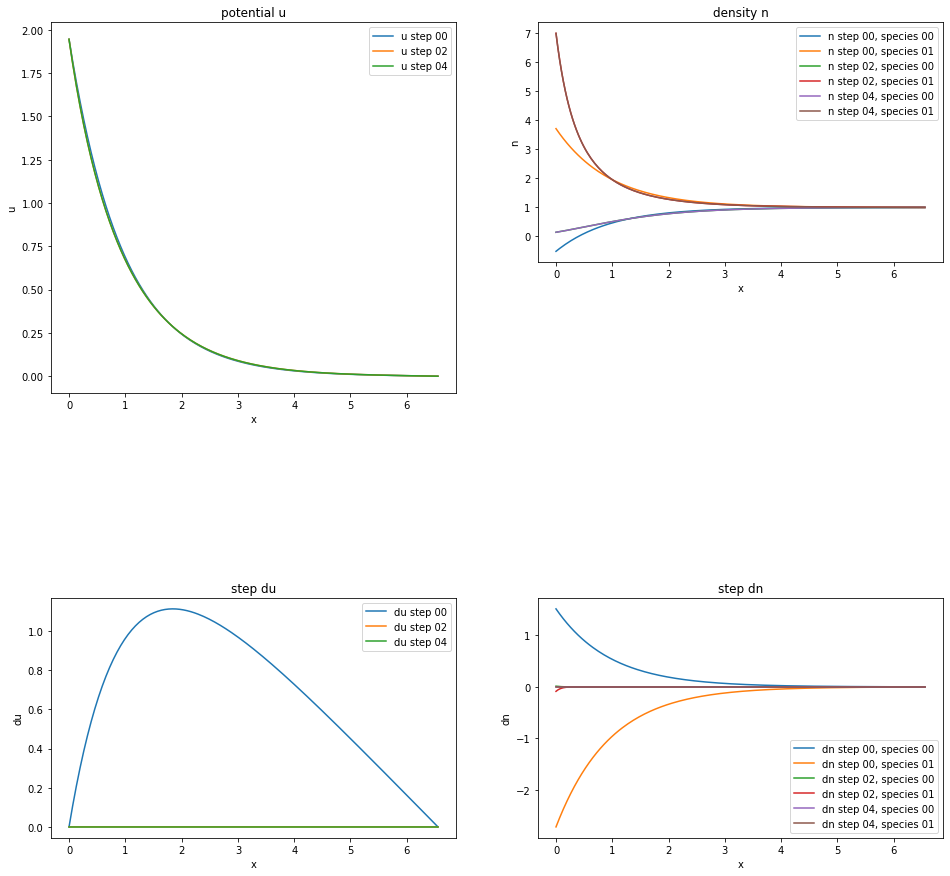

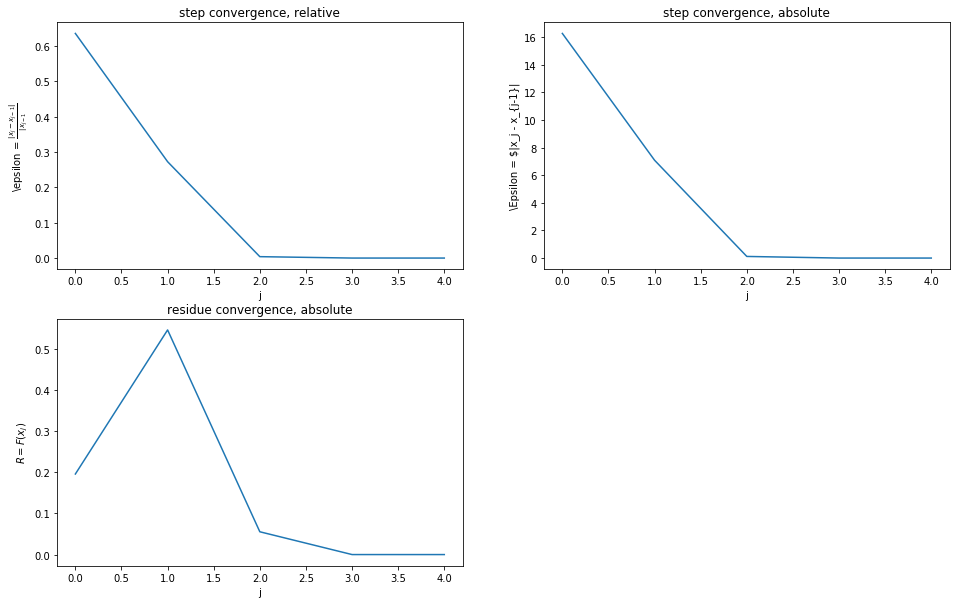

In [1203]:
uij, nij, lamj = pnp.solve()

### Validation: Analytical half-space solution & Numerical finite-size PNP system

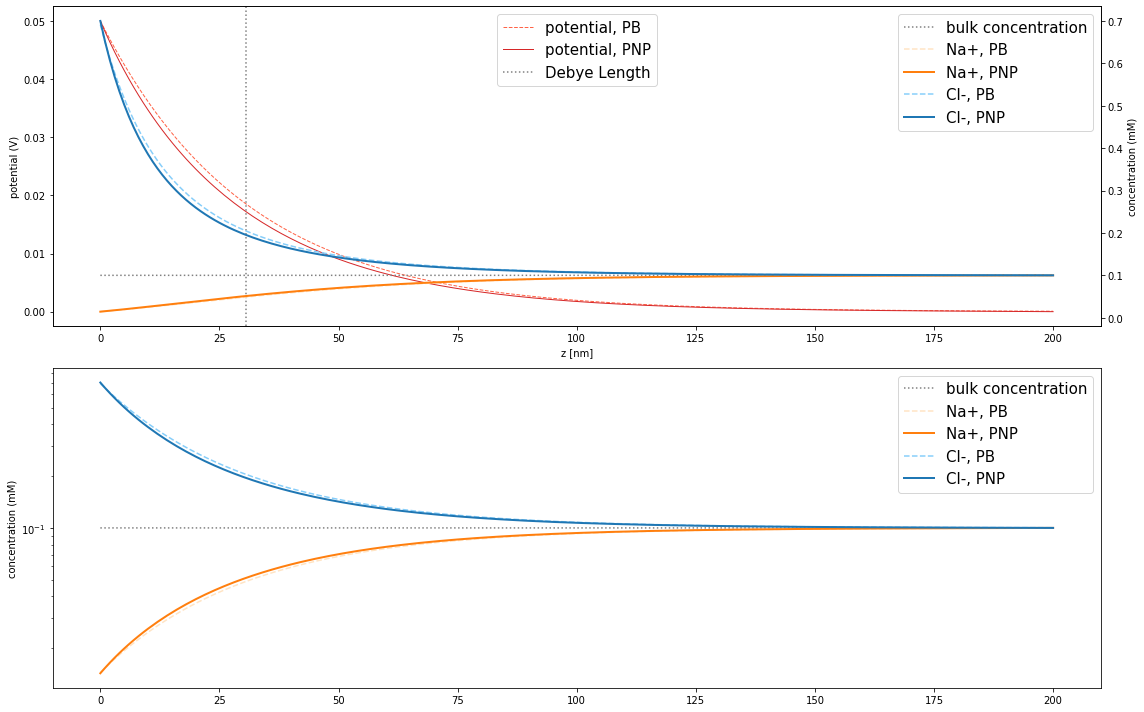

In [1205]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system

z = np.linspace(0, L, 2000)
density = sc.Avogadro * 1000 * 1e-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 1e9

fig, (ax1,ax3) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(z*1e9, psi, marker='', color='tomato', label='potential, PB', linewidth=1, linestyle='--')
ax1.plot(pnp.grid*1e9, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax1.set_ylabel('potential (V)')

ax2 = ax1.twinx()
ax2.plot(z*1e9, [density/sc.Avogadro]*len(z), label='bulk concentration', color='grey', linestyle=':')
ax2.plot(z*1e9, rho_na/sc.Avogadro, marker='', color='bisque', label='Na+, PB',linestyle='--')
ax2.plot(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax2.plot(z*1e9, rho_cl/sc.Avogadro, marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax2.plot(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax2.set_ylabel('concentration (mM)')

ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3.semilogy(z*1e9, [density/sc.Avogadro]*len(z), label='bulk concentration', color='grey', linestyle=':')
ax3.semilogy(z*1e9, rho_na/sc.Avogadro, marker='', color='bisque', label='Na+, PB',linestyle='--')
ax3.semilogy(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax3.semilogy(z*1e9, rho_cl/sc.Avogadro, marker='', color='lightskyblue', label='Cl-, PB',linestyle='--')
ax3.semilogy(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax3.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper center', fontsize=15)
ax2.legend(loc='best', fontsize=15)
ax3.legend(loc='upper right', fontsize=15)

fig.tight_layout()
plt.show()

### Construct arbitrary initial conditions for subsequent system

In [1206]:
csup = pnp.concentration[1]-pnp.concentration[0]

In [1207]:
scale_factor = np.sum(pnp.ni0[0]*pnp.c_unit) / np.sum(csup)

In [1208]:
scale_factor

1.4194391735664258

In [1209]:
ci0 = scale_factor*np.vstack((np.flip(csup),csup))

In [1248]:
ci0.shape

(2, 201)

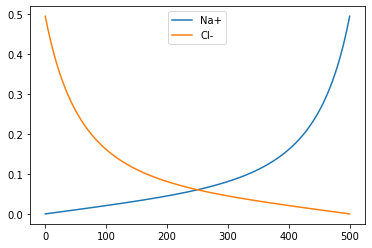

In [866]:
plt.plot(ci0[0], label='Na+')
plt.plot(ci0[1], label='Cl-')
plt.legend()

### 1D electrochemical cell

In [1292]:
del pnp

In [1293]:
pnp = PoissonNernstPlanckSystem(delta_u=0.05)

2019-10-29 20:53:33,318[ poisson_nernst_planck_distribution.py:682 - __init__() ]: ion species 00 concentration c                0.1
2019-10-29 20:53:33,319[ poisson_nernst_planck_distribution.py:684 - __init__() ]: ion species 00 number charge z                  1
2019-10-29 20:53:33,321[ poisson_nernst_planck_distribution.py:682 - __init__() ]: ion species 01 concentration c                0.1
2019-10-29 20:53:33,322[ poisson_nernst_planck_distribution.py:684 - __init__() ]: ion species 01 number charge z                 -1
2019-10-29 20:53:33,323[ poisson_nernst_planck_distribution.py:687 - __init__() ]: temperature T                               298.1
2019-10-29 20:53:33,325[ poisson_nernst_planck_distribution.py:689 - __init__() ]: domain size L                               1e-07
2019-10-29 20:53:33,325[ poisson_nernst_planck_distribution.py:691 - __init__() ]: potential difference delta_u                 0.05
2019-10-29 20:53:33,326[ poisson_nernst_planck_distribution.py:693 - 

In [1294]:
# technical settings
pnp.output = True # makes Newton solver display convergence plots
pnp.N = 500 # uniformlya distanced grid points
pnp.maxit = 20 # maximum number of Newton iterations
pnp.outfreq=2
pnp.e = 1e-12 # absolute tolerance

In [1295]:
pnp.useStandardCellBC()

2019-10-29 20:53:34,571[ poisson_nernst_planck_distribution.py:381 - useStandardCellBC() ]: Left hand side Dirichlet boundary condition:                               u0 =    0.973
2019-10-29 20:53:34,572[ poisson_nernst_planck_distribution.py:382 - useStandardCellBC() ]: Right hand side Dirichlet boundary condition:                              u1 =   -0.973
2019-10-29 20:53:34,572[ poisson_nernst_planck_distribution.py:393 - useStandardCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition:       j0 =        0
2019-10-29 20:53:34,573[ poisson_nernst_planck_distribution.py:395 - useStandardCellBC() ]: Ion species 00 number conservation constraint:                             N0 =    3.277
2019-10-29 20:53:34,573[ poisson_nernst_planck_distribution.py:393 - useStandardCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition:       j0 =        0
2019-10-29 20:53:34,573[ poisson_nernst_planck_distribution.py:395 - useStandardCellBC() ]: Ion

In [1296]:
pnp.init()

2019-10-29 20:53:34,851[ poisson_nernst_planck_distribution.py:246 - init() ]: discretization segments N                     500
2019-10-29 20:53:34,852[ poisson_nernst_planck_distribution.py:248 - init() ]: grid points N                                 501
2019-10-29 20:53:34,852[ poisson_nernst_planck_distribution.py:263 - init() ]: dx                                        0.006554
2019-10-29 20:53:34,853[ poisson_nernst_planck_distribution.py:265 - init() ]: dx2overtau                                     10


2019-10-29 20:53:35,388[ poisson_nernst_planck_distribution.py:145 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
2019-10-29 20:53:37,989[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    0: norm(dx)/norm(x) = 4.48e-01, norm(dx) = 1.53e+01, norm(F) = 1.23e-01
2019-10-29 20:53:43,672[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    2: norm(dx)/norm(x) = 1.04e-05, norm(dx) = 3.85e-04, norm(F) = 2.73e-05
2019-10-29 20:53:49,003[ poisson_nernst_planck_distribution.py:193 - newton() ]: Step    4: norm(dx)/norm(x) = 1.77e-11, norm(dx) = 6.55e-10, norm(F) = 7.63e-10
2019-10-29 20:53:51,548[ poisson_nernst_planck_distribution.py:218 - newton() ]: Ended after 6 steps.


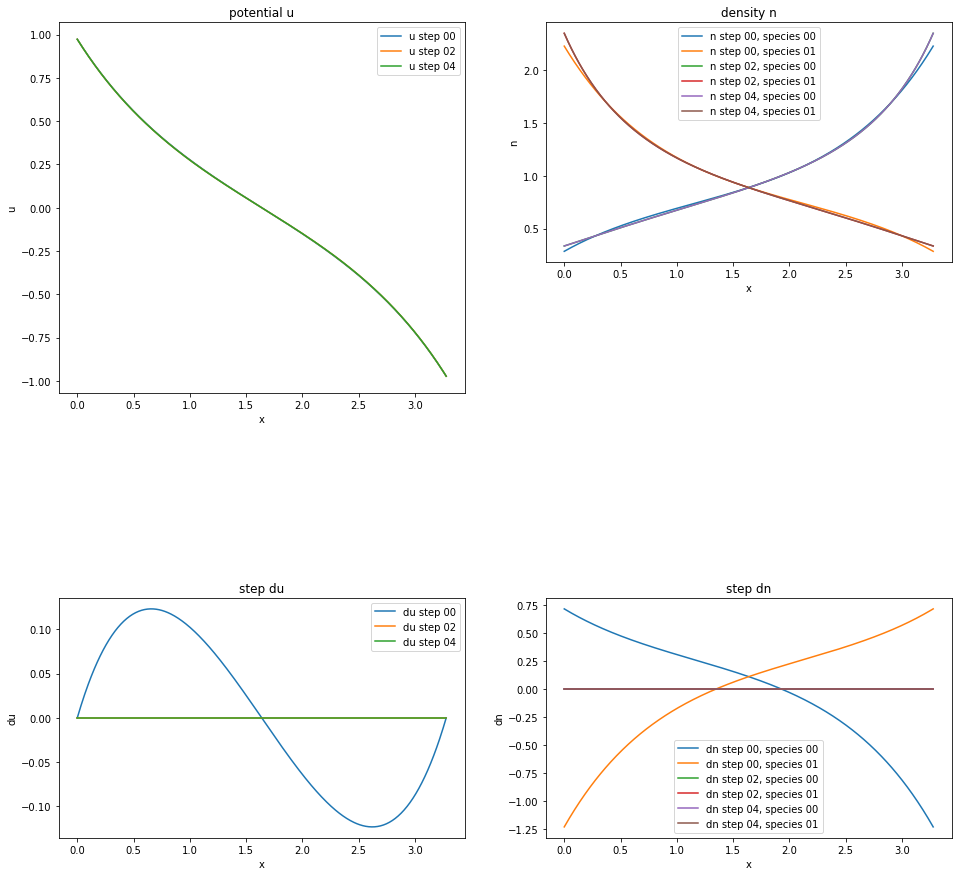

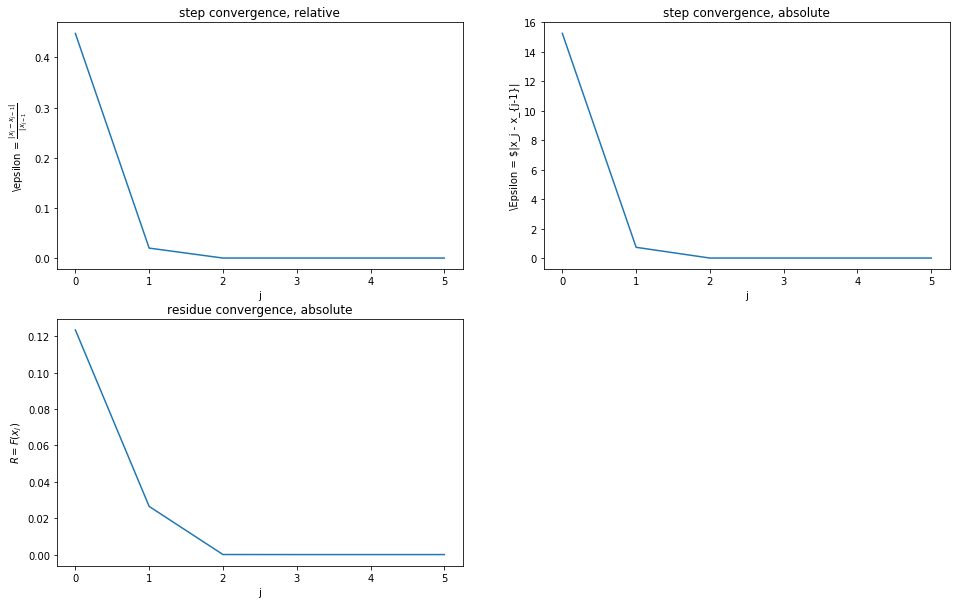

In [1297]:
xij = pnp.solve()

In [1298]:
pnp.concentration[0,0]

0.033593153029529484

In [1299]:
pnp.concentration[1,0]

0.23519390520587016

In [1300]:
pnp.concentration[0,-1]

0.23519384405328636

In [1301]:
pnp.concentration[1,-1]

0.033593148773251556

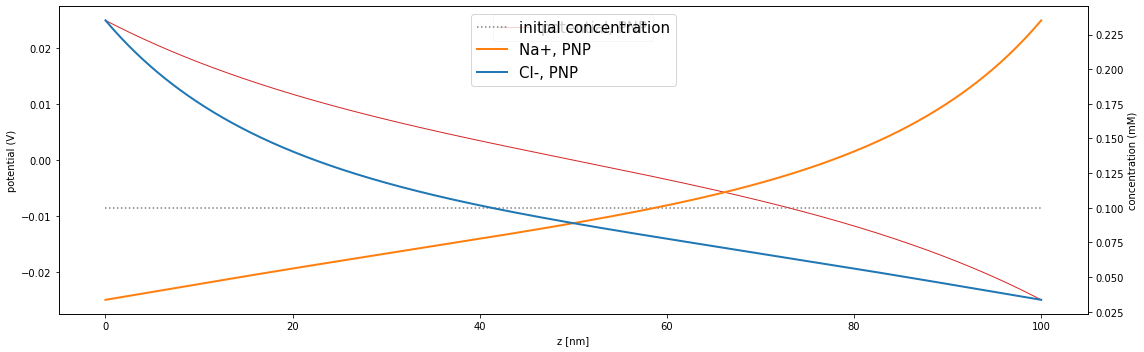

In [1302]:
fig, ax1 = plt.subplots(figsize=[16,5])
ax1.set_xlabel('z [nm]')

ax1.plot(pnp.grid*1e9, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax1.set_ylabel('potential (V)')

ax2 = ax1.twinx()
ax2.plot(pnp.grid*1e9, pnp.c[0]*np.ones(pnp.grid.shape), label='initial concentration', color='grey', linestyle=':')
ax2.plot(pnp.grid*1e9, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')


ax2.plot(pnp.grid*1e9, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax2.set_ylabel('concentration (mM)')


#ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

#fig.legend(loc='center')
ax2.legend(loc='best', fontsize=15)
ax1.legend(loc='upper center', fontsize=15)

fig.tight_layout()
plt.show()

In [1303]:
pnp.rightFluxBC(pnp.xij1,0)

1.8397974557091135e-06

In [1304]:
pnp.leftFluxBC(pnp.xij1,0)

9.71445146547012e-17

In [1305]:
pnp.rightFluxBC(pnp.xij1,1)

1.2631674066974907e-07

In [1306]:
pnp.leftFluxBC(pnp.xij1,1)

-2.282896094385478e-15

In [1307]:
pnp.leftFluxBC(pnp.xij1,1)

-2.282896094385478e-15

In [1308]:
pnp.numberConservationConstraint(pnp.xij1,0,0)

3.276830376498542

In [1309]:
pnp.numberConservationConstraint(pnp.xij1,1,0)

3.276830376498542

In [1310]:
pnp.numberConservationConstraint(pnp.xi0,0,0)

3.276830376498542

In [1311]:
pnp.numberConservationConstraint(pnp.xij1,1,0)

3.276830376498542

#### On constraints

According to https://theochem.github.io/horton/2.1.0/user_postproc_espfit.html, cost function is constructed as

$$ c(\mathbf{q}, \Delta V_\text{ref}) = \int_V d\mathbf{r} \omega(\mathbf{r}) \cdot \left( V_\text{ab initio}(\mathbf{r}) - \sum_{i=1}^N \frac{q_i}{\mathbf{r} - \mathbf{R}_i} - \Delta V_\text{ref} \right)^2  $$

> $\Delta V_\text{ref}$: constant that may account for differences in reference between the ab initio ESP and the point charge ESP. The need for such a term was established in the REPEAT paper for ESP fitting in 3D periodic systems.

We look at an aperiodic system, neglect this term for now. The (unconstrained) cost function takes the general quadratic form

$$ c_u(\mathbf{x}) = \mathbf{x}^T A\ \mathbf{x} - 2 \mathbf{b}^T \mathbf{x} - C $$

with 

$$ C = - \int_V d\mathbf{r} \omega(\mathbf{r}) \cdot \left[ V_\text{ab initio}(\mathbf{r}) \right]^2$$

entry i,j of matrix $A^{N\times N}$

$$  A_{ij} = \int_V d\mathbf{r}\ \omega(\mathbf{r}) \cdot \left( \frac{1}{|\mathbf{r} - \mathbf{R}_i|} \cdot \frac{1}{|\mathbf{r} - \mathbf{R}_j|} \right)  $$

and entry i of vector $\mathbf{b}$

$$  b_i = \int_V d\mathbf{r}\ \omega(\mathbf{r}) \cdot \frac{V_\text{ab initio}(\mathbf{r})}{|\mathbf{r} - \mathbf{R}_i|} $$

In the code below, first the miniumum of an unconstrained system is found by solving

$$ \frac{1}{2} \cdot \frac{\mathrm{d} c(\mathbf{x})}{\mathrm d  \mathbf{x}}  = \frac{1}{2} \cdot \nabla_\mathbf{x} c = A \mathbf{x} - \mathbf{b} = 0$$

with $\nabla (\mathbf{b}^T \mathbf{x}) = \mathbf{b}$ and 
$\nabla \cdot (\mathbf{x}^T A \mathbf{x}) = (A + A^T) \mathbf{x} 
= 2 A \mathbf{x} $ for symmetric A, as in our case. 
The (unconstrained) solution

$$ \mathbf{x}_u = A^{-1} \mathbf{b} $$

is corrected for *one* total charge constraint of the form 

$$ g(\mathbf{x}) = \mathbf{d} \cdot \mathbf{x} - q_\text{tot} = 0 $$

with all entries of $\mathbf{d}$ unity. Notice that in the code below, the whole system is normalized in order to have unity diagonal entries $A_{jj}$. We neglect this normalization here.

A Lagrange multiplier $\lambda$ is introduced into the *constrained* cost function 

$$ c_c(\mathbf{x},\lambda) = \mathbf{x}^T A\ \mathbf{x} - 2 \mathbf{b}^T \mathbf{x} - C + \lambda \cdot  g(\mathbf{x}) $$

and the system

$$ \frac{1}{2} \cdot \nabla_\mathbf{x} c = A \mathbf{x} - \mathbf{b} + \lambda \cdot \nabla_\mathbf{x} g(\mathbf{x}) = A \mathbf{x} - \mathbf{b} +\lambda \cdot \mathbf{d} = 0 $$

$$  \nabla_\mathbf{\lambda} c = g(\mathbf{x}) = \mathbf{d} \cdot \mathbf{x} - q_\text{tot} = 0 $$

is solved by finding a correction for the unconstrained solution

$$ \mathbf{x} = \mathbf{x}_u - \lambda \cdot\delta \mathbf{x} = A^{-1} \mathbf{b} - \lambda \cdot \delta \mathbf{x} $$

as 

$$ - \lambda A \delta \mathbf{x} + \lambda \cdot \mathbf{d} = 0 
\Leftrightarrow \delta \mathbf{x} = A^{-1} \mathbf{d}$$

and the Lagrange multiplier by

$$ g(\mathbf{x}) 
    = \mathbf{d} \cdot \left( \mathbf{x}_u 
        - \lambda \ \delta \mathbf{x} \right)- q_\text{tot} 
    = \mathbf{d} \cdot A^{-1} \mathbf{b} 
        - \lambda \ \mathbf{d} \cdot \delta \mathbf{x} - q_\text{tot} 
    = 0 $$

$$ \lambda = \frac{\mathbf{d} \cdot A^{-1} \mathbf{b} - q_\text{tot}}
    { \mathbf{d} \cdot \delta \mathbf{x} }
    = \frac{\mathbf{b} \cdot \delta \mathbf{x} - q_\text{tot}}
    { \mathbf{d} \cdot \delta \mathbf{x} }$$
    
    
and thereby the constrained minimum at
$$ \mathbf{x} 
    = \mathbf{x}_u 
        - \frac{\mathbf{b} \cdot \delta \mathbf{x} - q_\text{tot}}
        { \mathbf{d} \cdot \delta \mathbf{x} } 
        \cdot \delta \mathbf{x}$$
        
as implemented in HORTON

We modifiy the optimization in order to allow for an arbitrary amount of constraints.

M lagrange multipliers $\lambda_k$ are introduced into the *constrained* cost function 

$$ c_c(\mathbf{x},\mathbf{\lambda}) = \mathbf{x}^T A\ \mathbf{x} - 2 \mathbf{b}^T \mathbf{x} - C + \sum_{k=1}^M \lambda_k \cdot  g_k(\mathbf{x}) $$

All our constraints (charge groups and symmetries) will be of linear form 

$$ g_k(\mathbf{x}) = \mathbf{d}_k \cdot \mathbf{x} - q_k = 0 $$

and thus can be compacted into matrix form

$$ D^{(M \times N)} \mathbf{x} - \mathbf{q}^{(M\times 1)} = 0 $$

with 

$$ D^T = [\mathbf{d}_1, \mathbf{d}_2, \dots , \mathbf{d}_M] $$

and hence 
$$ c_c(\mathbf{x}^{(N\times1)},\mathbf{\lambda}^{(M\times1)}) = \mathbf{x}^T A\ \mathbf{x} 
    - 2 \mathbf{b}^T \mathbf{x} 
    - C + \mathbf{\lambda}^T \cdot \left( D \mathbf{x} - \mathbf{q} \right) $$

Derivative 

$$ 
\begin{align}
    \nabla_\mathbf{x} \cdot c_c & = 2\ A\ \mathbf{x} 
    + \sum_{k=1}^M \lambda_k \mathbf{d}_k - 2 \mathbf{b} & = 0\\
    \nabla_\mathbf{\lambda} \cdot c_c & = D\ \mathbf{x} - \mathbf{q} & = 0
\end{align}
$$

Identify 

$$ D^T \mathbf{\lambda}= \sum_{k=1}^M \lambda_k \mathbf{d}_k  $$

and solve

$$ \tilde{A} \mathbf{y} - \tilde{\mathbf{b}} = 0$$ 

with generalized $\mathbf{y}^T = [\mathbf{x}^T, \mathbf{\lambda}^T ]$ 
as well as $(N+M)\times(N+M)$ matrix

$$ \tilde{A} = 
    \begin{bmatrix}
        2 A & D^T \\
        D & 0
    \end{bmatrix} $$
    
and $(N+M)$ vector

$$ \tilde{\mathbf{b}} =  
   \begin{bmatrix}
        2 \mathbf{b} \\
        \mathbf{q}
   \end{bmatrix} $$